# vote_coefficients_0xAA40E2E5c8df03d792A52B5458959C320F86ca18_1


In [1]:
import os
from pathlib import Path
import numpy as np

import pandas as pd

from sbdata.FlipsideApi import FlipsideApi

# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', 'all_beta_rounds')
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
CSV_GITCOIN_GRANTS = 'vote_coefficients_0x12BB5bBbFE596dbc489d209299B8302c3300fa40_4.csv'

# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)
PATH_TO_VOTES = os.path.join(DATA_DIR, "votes_baoki.csv")
PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")
PATH_TO_VOTES_GITCOIN = os.path.join(DATA_DIR_GITCOIN, CSV_GITCOIN_GRANTS)

# load data
df_votes = pd.read_csv(PATH_TO_VOTES_GITCOIN)
df_grants = pd.read_csv(PATH_TO_GRANTS)
df_application = pd.read_csv(PATH_TO_PROJECTS)
# Lowercase all addresses because flipside api return lowercase address
#id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,status,last_score_timestamp,type,success,rawScore,threshold
df_grants['Round ID'] = df_grants['Round ID'].str.lower()
str_columns_votes = ['id', 'projectId', 'roundId', 'voter', 'grantAddress']
df_votes[str_columns_votes] = df_votes[str_columns_votes].applymap(lambda x: x.lower())

str_columns_application = ['id', 'roundId', 'metadata.application.round', 'metadata.application.recipient']
df_application[str_columns_application] = df_application[str_columns_application].applymap(lambda x: str(x).lower())

# round_id = df_grants[df_grants['Round name'] == 'Web3 Community and Education']['Round ID'].values[0]
array_unique_address = df_votes['voter'].unique()

array_unique_address = np.char.lower(array_unique_address.astype(str))


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_9816\1947096817.py:26: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes = pd.read_csv(PATH_TO_VOTES_GITCOIN)


In [2]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx('ethereum', array_unique_address)

In [3]:
len(array_unique_address)

14554

In [4]:
df_tx.EOA.nunique()

14554

In [5]:
c = np.setxor1d(array_unique_address, df_tx.EOA.values)
c

array([], dtype=object)

## Computing legos booleans

In [6]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(np.intersect1d(df_tx.EOA.unique(), array_unique_address), columns=['address']))

use matching address because some addresses are not in the extracted data set

In [7]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x00000000037a08ce8c4917a5c58f40c85367df0c
1,0x00000001985c6a08963eef53821c78aa84318b42


Compute the boolean 

less than 10 x transaction are not performant legos so we don't use it, has same seed is computed as an intermediarry to get the seed_suspicious flag

In [8]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [9]:
df_matching_address['lcs'] = 0
df_matching_address[df_matching_address['less_10_tx'] == True].shape
r = df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'address'].apply(lambda x: tx_analyser.transaction_similitude_pylcs(x, minimum_sim_tx=3))

In [10]:
def lcs_to_array(lcs):
    if lcs.shape[0] == 0:
        return []
    else:
        return np.asarray(lcs.reset_index())

def get_mean_score_lcs(lcs):
    if lcs.shape[0] == 0:
        return 0
    else:
        return lcs.reset_index()['score'].mean()
    
def get_max_score_lcs(lcs):
    if lcs.shape[0] == 0:
        return 0
    else:
        return lcs.reset_index()['score'].max()
    
df_matching_address['cluster_size_lcs'] = 0
df_matching_address['mean_score_lcs'] = 0
df_matching_address['max_score_lcs'] = 0

df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'cluster_size_lcs'] = r.apply(lambda x: len(x))
df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'mean_score_lcs'] = r.apply(lambda x: get_mean_score_lcs(x))
df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'max_score_lcs'] = r.apply(lambda x: get_max_score_lcs(x))

df_matching_address['has_lcs'] = df_matching_address['cluster_size_lcs'] > 0

print((df_matching_address[df_matching_address['less_10_tx'] == True]['cluster_size_lcs'] > 0).sum())

425


In [11]:
print(f'Number of voters: {len(df_matching_address)}')

Number of voters: 14554


In [12]:
df_matching_address.sum()

address                  0x00000000037a08ce8c4917a5c58f40c85367df0c0x00...
seed_same_naive                                                      10325
seed_same                                                            10758
seed_suspicious                                                        489
less_5_tx                                                              229
less_10_tx                                                             917
interacted_other_ctbt                                                 3994
lcs                                                                      0
cluster_size_lcs                                                      2969
mean_score_lcs                                                   53.201528
max_score_lcs                                                    56.699527
has_lcs                                                                425
dtype: object

### Investigating the boolean seed suspicious

In [13]:
df_matching_address[df_matching_address['seed_suspicious'] == True]

,address,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs
42,0x006970fd32059734e586a323b13fc1ce625f296b,False,True,True,False,False,False,0,0,0.000000,0.000000,False
43,0x006ad7df1dfad4af7d182b9598a294d7c601488b,False,True,True,False,False,False,0,0,0.000000,0.000000,False
60,0x00bb8b005d090b6a59aa5c9550f3f9629edb18bf,False,True,True,False,False,False,0,0,0.000000,0.000000,False
61,0x00bf528c0e7ce508e6c20642fdae6b8728e4122b,False,True,True,False,False,True,0,0,0.000000,0.000000,False
97,0x0150c608a25176c08d9bc8b43d0dc64e4c9f4a58,False,True,True,False,False,False,0,0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...
14488,0xfeeda41a603ea7da0b8638ac885be0b2399b4b29,False,True,True,False,False,False,0,0,0.000000,0.000000,False
14495,0xff17b13fde1b3738b473d24ca640379f8e163738,False,True,True,False,False,False,0,0,0.000000,0.000000,False
14525,0xff938bd81c2671c28caf920d8015bad9fb816d59,False,True,True,False,False,True,0,0,0.000000,0.000000,False
14531,0xffa95c8ea548c484e0c40d5e985237db070d6211,False,True,True,False,False,False,0,0,0.000000,0.000000,False


Some of the projects he donated to are in the list of Rejected projects showing that this address is indeed a sybil. And may have contributed to ohter fraudulent projects.

- Pulsar is not very active and is forked code for the most part
- Fusion not very active on github but has a lot of activity on twitter 
- Share suspicious Github with no activity, twitter does not exists: suspicious

Other projects are ok

The boolean seed suspicious is not relevant for that round we will not use it for the analysis.

### Computing the new dex interaction score
It was investigated in another notebook 

In [14]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [18]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [19]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [20]:
tx_analyser.set_group_by_sorted_EOA()

In [21]:
# Compute the number of interactions with any of the pools for each address
df_matching_address['count_interaction_with_pool'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [22]:
(df_matching_address['count_interaction_with_pool'] > 0).sum() / len(df_matching_address)

0.35103751545966744

From these tags lets flag any address that have interacted with a toxic wallet

In [23]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'toxic'
;'''
df_toxic = flipside_api.execute_query(label_query)

In [24]:
df_toxic.shape

(4857, 6)

In [25]:
# Compute the number of interactions with any of the scam for each address
df_matching_address['count_interaction_with_toxic'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_toxic['address'].unique()))

In [26]:
print(f'Percentage of addresses that have interacted with a toxic address: {int((df_matching_address["count_interaction_with_toxic"] > 0).sum() / len(df_matching_address) *100)}%')

Percentage of addresses that have interacted with a toxic address: 1%


I found the tag_name "airdrop master" could be interesting 

In [27]:
query_airdrop_master = '''
SELECT BLOCKCHAIN, CREATOR, ADDRESS, TAG_NAME
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
AND TAG_NAME = 'airdrop master'
;
'''
df_airdrop_master = flipside_api.execute_query(query_airdrop_master)

In [28]:
# Compute the number of interactions with any of the aidrop for each address
df_matching_address['count_interaction_with_airdrop_m'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_airdrop_master['address'].unique()))
print(f'Percentage of addresses that interacted with airdrop master: {int((df_matching_address["count_interaction_with_airdrop_m"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with airdrop master: 14%


In [30]:
# Boolean whether the address is a aidrop master
df_matching_address['is_airdrop_master'] = df_matching_address['address'].apply(lambda x: x in df_airdrop_master['address'].unique()) 
print(f'Percentage of addresses that are airdrop master: {int((df_matching_address["is_airdrop_master"]).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that are airdrop master: 5%


In [31]:
sql_query_tornado = '''
SELECT DISTINCT PROJECT_NAME, ADDRESS
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND PROJECT_NAME LIKE '%tornado%'
;
'''
df_tornado = flipside_api.execute_query(sql_query_tornado)

In [32]:
# Count the number of interactions with tornado
df_matching_address['count_interaction_with_tornado'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_tornado['address'].unique()))
print(f'Percentage of addresses that interacted with tornado: {int((df_matching_address["count_interaction_with_tornado"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with tornado: 1%


In [33]:
# Count the number of time the address interatec with disperse contract: '0xD152f549545093347A162Dce210e7293f1452150'
df_matching_address['count_interaction_with_disperse'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, [str.lower('0xD152f549545093347A162Dce210e7293f1452150')]))
print(f'Percentage of addresses that interacted with disperse: {int((df_matching_address["count_interaction_with_disperse"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with disperse: 1%


In [34]:
df_matching_address.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,count_interaction_with_pool,count_interaction_with_toxic,count_interaction_with_airdrop_m,count_interaction_with_tornado,count_interaction_with_disperse
count,14554.0,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000
mean,0.0,0.203999,0.003655,0.003896,4.003710,0.041432,1.687990,0.041157,0.098530
std,0.0,1.902078,0.021802,0.023348,28.982165,0.748714,11.881739,0.788599,3.471618
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
90%,0.0,0.000000,0.000000,0.000000,8.000000,0.000000,2.000000,0.000000,0.000000
max,0.0,56.000000,0.200000,0.200000,2632.000000,56.000000,600.000000,55.000000,388.000000


In [35]:
df_matching_address['has_interaction_toxic'] = df_matching_address['count_interaction_with_toxic'] > 0
df_matching_address['has_no_pool_interaction'] = df_matching_address['count_interaction_with_pool'] < 6
df_matching_address['has_interaction_airdrop_m'] = df_matching_address['count_interaction_with_airdrop_m'] > 0
df_matching_address['has_interaction_tornado'] = df_matching_address['count_interaction_with_tornado'] > 0
df_matching_address['has_interaction_disperse'] = df_matching_address['count_interaction_with_disperse'] > 0

In [36]:
boolean_features = ['has_lcs', 'seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_airdrop_m', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'interacted_other_ctbt']

In [37]:
df_matching_address[boolean_features].sum() 

has_lcs                        425
seed_suspicious                489
has_interaction_toxic          283
has_no_pool_interaction      12670
has_interaction_airdrop_m     2042
has_interaction_tornado        155
has_interaction_disperse       192
is_airdrop_master              831
interacted_other_ctbt         3994
dtype: int64

In [38]:
len(df_matching_address)

14554

### Look at the addresses with at least one flag

We are going to review the addresses that have at least 1 flag:
- has_intercation_toxic 
- has_interaction_disperse
- has_interaction_airdrop_master
- is airdrop master
- seed suspicious
- interacted with other contributor and less than 5 tx

I decided to remove tornado cash because someone can be anonimous with out being a sybil

In [40]:
df_matching_address['interact_less_5tx'] = np.logical_and(df_matching_address['interacted_other_ctbt'], df_matching_address['less_5_tx'])

In [41]:
interaction_bool = ['has_lcs', 'has_interaction_toxic', 'has_interaction_airdrop_m', 'has_interaction_disperse', 'is_airdrop_master', 'seed_suspicious', 'interact_less_5tx']

In [42]:
df_matching_address[interaction_bool].sum()

has_lcs                       425
has_interaction_toxic         283
has_interaction_airdrop_m    2042
has_interaction_disperse      192
is_airdrop_master             831
seed_suspicious               489
interact_less_5tx              27
dtype: int64

In [43]:
from scipy.spatial.distance import pdist

def jaccard_similarity_matrix(df):
    
    n = df.shape[1]
    scores = 1 - pdist(np.array(df).T, metric='jaccard')
    result = np.zeros((n,n))
    result[np.triu_indices(n, k=1)] = scores
    result += result.T
    np.fill_diagonal(result, 1)
    return pd.DataFrame(result, index=df.columns, columns=df.columns)

jaccard_similarity = jaccard_similarity_matrix(df_matching_address[interaction_bool])
jaccard_similarity

,has_lcs,has_interaction_toxic,has_interaction_airdrop_m,has_interaction_disperse,is_airdrop_master,seed_suspicious,interact_less_5tx
has_lcs,1.000000,0.000000,0.000000,0.000000,0.000000,0.015556,0.000000
has_interaction_toxic,0.000000,1.000000,0.085434,0.055556,0.075290,0.006519,0.000000
has_interaction_airdrop_m,0.000000,0.085434,1.000000,0.048334,0.327634,0.012805,0.000000
has_interaction_disperse,0.000000,0.055556,0.048334,1.000000,0.051387,0.004425,0.000000
is_airdrop_master,0.000000,0.075290,0.327634,0.051387,1.000000,0.010720,0.000000
seed_suspicious,0.015556,0.006519,0.012805,0.004425,0.010720,1.000000,0.013752
interact_less_5tx,0.000000,0.000000,0.000000,0.000000,0.000000,0.013752,1.000000


<Axes: >

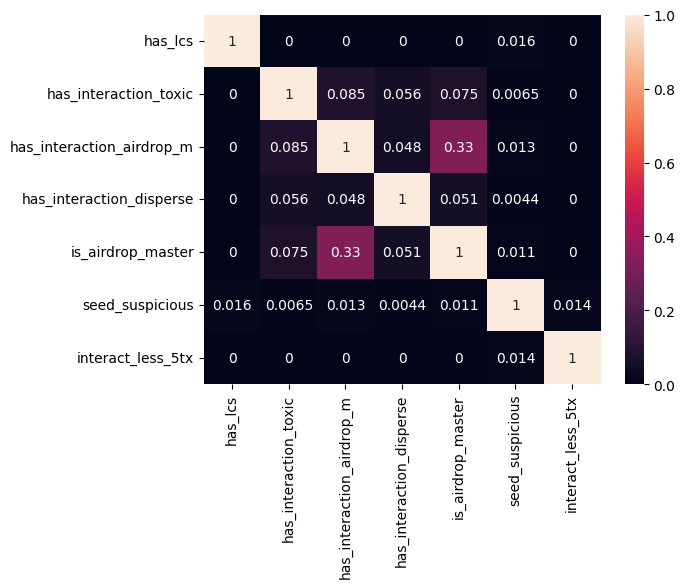

In [44]:
import seaborn as sns
sns.heatmap(jaccard_similarity, annot=True)

In [45]:
df_matching_address['flagged'] = df_matching_address[interaction_bool].sum(axis=1) > 0
df_interact_sus_2 = df_matching_address[df_matching_address['flagged'] == True]
print(f'Number of addresses that interacted with a suspicious contract or address: {df_interact_sus_2.shape[0]}')

Number of addresses that interacted with a suspicious contract or address: 3226


In [52]:
boolean_to_keep = ['has_lcs', 'seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'has_interaction_airdrop_m', 'interacted_other_ctbt', 'interact_less_5tx', 'flagged']

In [53]:
df_matching_address[boolean_to_keep].sum()

has_lcs                        425
seed_suspicious                489
has_interaction_toxic          283
has_no_pool_interaction      12670
has_interaction_tornado        155
has_interaction_disperse       192
is_airdrop_master              831
has_interaction_airdrop_m     2042
interacted_other_ctbt         3994
interact_less_5tx               27
flagged                       3226
dtype: int64

In [54]:
final_merge = df_votes.merge(df_matching_address, left_on='voter', right_on='address', how='left')
print(f'number of squelched votes out of {final_merge.shape[0]}')
final_merge.shape[0] - final_merge[['coefficient']].sum() 

number of squelched votes out of 81811


coefficient    5598
dtype: int64

In [55]:
print(df_votes.shape)
print(final_merge.shape)

(81811, 16)
(81811, 41)


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_9816\2681738413.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))


(81811, 19) votes stephi
(81811, 41) final merge
(81811, 43) votes merge


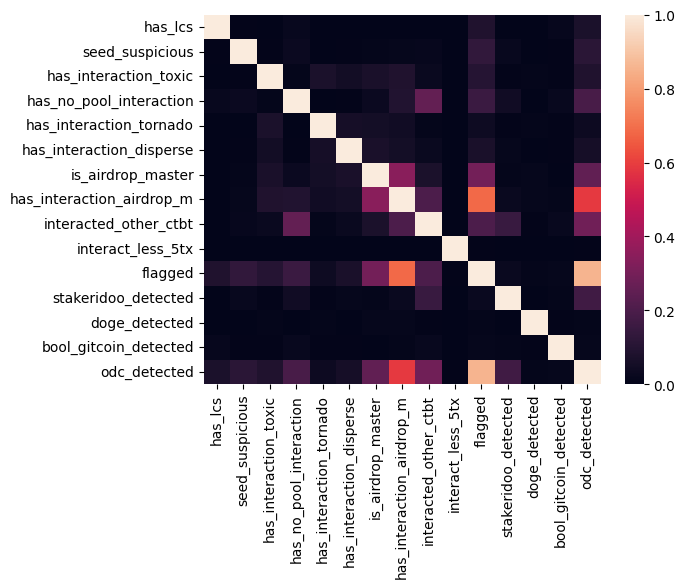

In [56]:
# Adding Stakeriddo and Gray flagged wallet

DATA_DIR_STEFI = os.path.join(current_dir.parent.parent, 'stefi')
CSV_STEPHI = 'sso_odc_analysis.csv'

# load data
df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))
print(f'{df_votes_stephi.shape} votes stephi')
print(f'{final_merge.shape} final merge')
df_stephi_bool_voter = df_votes_stephi[['voter', 'stakeridoo_detected', 'doge_detected']]
df_merge = final_merge.merge(df_stephi_bool_voter.drop_duplicates(subset=['voter']), left_on='voter', right_on='voter', how='left')
print(f'{df_merge.shape} votes merge')

df_merge['bool_gitcoin_detected'] = np.logical_not(df_merge.success.astype(bool))
df_merge['stakeridoo_detected'].fillna(False, inplace=True)
df_merge['doge_detected'].fillna(False, inplace=True)
df_merge['odc_detected'] = np.logical_or(np.logical_or(df_merge['stakeridoo_detected'], df_merge['doge_detected']), df_merge['flagged'])

boolean_jaccard = boolean_to_keep + ['stakeridoo_detected', 'doge_detected', 'bool_gitcoin_detected', 'odc_detected']
jaccard_similarity_2 = jaccard_similarity_matrix(df_merge[boolean_jaccard])
sns.heatmap(jaccard_similarity_2)

df_merge['proposed_coeff'] = np.logical_not(np.logical_or(df_merge['odc_detected'], df_merge['bool_gitcoin_detected']))

df_merge.drop(columns=['bool_gitcoin_detected', 'address']).to_csv(f'../output_gitcoin/n_{CSV_GITCOIN_GRANTS}', index=False)

In [57]:
df_merge[boolean_jaccard].sum(axis=0)

has_lcs                       1498
seed_suspicious               2319
has_interaction_toxic         1763
has_no_pool_interaction      69503
has_interaction_tornado       1271
has_interaction_disperse      1192
is_airdrop_master             5230
has_interaction_airdrop_m    12198
interacted_other_ctbt        22821
interact_less_5tx               83
flagged                      17754
stakeridoo_detected           3527
doge_detected                  215
bool_gitcoin_detected         1635
odc_detected                 20753
dtype: int64

In [62]:
df_merge[df_merge['has_lcs'] == True]

,id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,...,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,interact_less_5tx,flagged,stakeridoo_detected,doge_detected,bool_gitcoin_detected,odc_detected,proposed_coeff
255,0x374d108569601c9ce2e534bc7065f1d5e9f01b998590...,0xcc6d33fe291d0fafb19cf8b833dc27d2f469fac52e3c...,43,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0xbf0218296dbd6ac24b7b358427c840556d6c0fb6,0x5afc7720b161788f9d833555b7ebc3274fd98da1,20000000000000000,37.409845,1,...,False,False,False,False,True,False,False,False,True,False
256,0x57c5bc3d5853cc90fd5a76f0f8bfe78e929766c802c5...,0xfb5b07f162ab081bf8608d275e9d595a331e0b36b2e4...,15,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0xbf0218296dbd6ac24b7b358427c840556d6c0fb6,0xf503017d7baf7fbc0fff7492b751025c6a78179b,1000000000000000,1.870492,1,...,False,False,False,False,True,False,False,False,True,False
257,0xdfff1a71381dcab5d2780d8fcb37975361189de797ab...,0xafb022ea11846bceb90516c35155defd6404e4948697...,87,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0xbf0218296dbd6ac24b7b358427c840556d6c0fb6,0x99b36fdbc582d113af36a21eba06bfeab7b9be12,1000000000000000,1.870492,1,...,False,False,False,False,True,False,False,False,True,False
258,0x248d084921d6173605052a547a1b9a55fd19c3d2b8da...,0xf8c209e714261f23f9390b8fae720ea280fe14b84f48...,63,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0xbf0218296dbd6ac24b7b358427c840556d6c0fb6,0x6ea869b6870dd98552b0c7e47da90702a436358b,1000000000000000,1.870492,1,...,False,False,False,False,True,False,False,False,True,False
259,0xdf19ebce476eba515b7c38b2ae81a3396b73cbbe2619...,0x0a55058c4e4ec1b799a6101fe5c9eac8277d7864515f...,142,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0xbf0218296dbd6ac24b7b358427c840556d6c0fb6,0x97843608a00e2bbc75ab0c1911387e002565dede,2000000000000000,3.740985,1,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80867,0xac58ea3b241f55e8e6c46cbb59c82dc6beae703c94b9...,0xfb5b07f162ab081bf8608d275e9d595a331e0b36b2e4...,15,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0x5d0b0a723bb755429d292e1768c5d105c35877b0,0xf503017d7baf7fbc0fff7492b751025c6a78179b,610000000000000,1.122338,1,...,False,False,False,False,True,False,False,False,True,False
80868,0xed14e068d45a67ce69f6bf1382b041130a4a2def60cb...,0xb746c0f648f9b930ea4568cf8741067a7fc7eb3928ac...,40,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0x5d0b0a723bb755429d292e1768c5d105c35877b0,0x4d9339dd97db55e3b9bcbe65de39ff9c04d1c2cd,610000000000000,1.122338,1,...,False,False,False,False,True,False,False,False,True,False
80869,0xb8748b45bac082445439110d70ba8cf7e6b010b46ae6...,0x60c037f9dfa5daee0f07bc26fb73393ef924e36c73c4...,18,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0x5d0b0a723bb755429d292e1768c5d105c35877b0,0x18aa467e40e1defb1956708830a343c1d01d3d7c,610000000000000,1.122338,1,...,False,False,False,False,True,False,False,False,True,False
80870,0x4c278ef43966168f481ebb6a67ac324048cc85e4fd1b...,0xe8d3a5b6bdbf0d28545bacff60d88a98c268535d2df1...,105,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,0x0000000000000000000000000000000000000000,0x5d0b0a723bb755429d292e1768c5d105c35877b0,0xdb0c831283c003686aef40ca228e42bdabf6674c,610000000000000,1.122338,1,...,False,False,False,False,True,False,False,False,True,False


In [67]:
df_merge[df_merge['has_lcs'] == True].grantAddress.describe()   

count                                           1498
unique                                            53
top       0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3
freq                                             197
Name: grantAddress, dtype: object

In [94]:
df_application.columns

Index(['id', 'projectNumber', 'roundId', 'status', 'amountUSD', 'votes',
       'uniqueContributors', 'createdAtBlock', 'statusUpdatedAtBlock',
       'metadata.signature', 'metadata.application.round',
       'metadata.application.recipient',
       'metadata.application.project.lastUpdated',
       'metadata.application.project.createdAt',
       'metadata.application.project.id', 'metadata.application.project.title',
       'metadata.application.project.description',
       'metadata.application.project.website',
       'metadata.application.project.logoImg',
       'metadata.application.project.metaPtr.protocol',
       'metadata.application.project.metaPtr.pointer',
       'metadata.application.project.userGithub',
       'metadata.application.project.projectGithub',
       'metadata.application.project.projectTwitter',
       'metadata.application.answers',
       'metadata.application.project.bannerImg',
       'metadata.application.project.credentials.twitter.@context',
       

In [95]:
df_application[df_application["metadata.application.project.title"].str.lower().str.contains('jedi')]["metadata.application.recipient"]

19    0x18aa467e40e1defb1956708830a343c1d01d3d7c
Name: metadata.application.recipient, dtype: object

In [108]:
jedi_swap = df_merge[df_merge['grantAddress'].str.lower() == str.lower('0x18aa467E40E1deFB1956708830A343c1D01d3D7C')]

In [110]:
jedi_swap['voter'].nunique()

9506

In [111]:
jedi_swap['voter'].shape

(9710,)

In [112]:
jedi_swap.columns

Index(['id', 'projectId', 'applicationId', 'roundId', 'token', 'voter',
       'grantAddress', 'amount', 'amountUSD', 'coefficient', 'status',
       'last_score_timestamp', 'type', 'success', 'rawScore', 'threshold',
       'address', 'seed_same_naive', 'seed_same', 'seed_suspicious',
       'less_5_tx', 'less_10_tx', 'interacted_other_ctbt', 'lcs',
       'cluster_size_lcs', 'mean_score_lcs', 'max_score_lcs', 'has_lcs',
       'count_interaction_with_pool', 'count_interaction_with_toxic',
       'count_interaction_with_airdrop_m', 'is_airdrop_master',
       'count_interaction_with_tornado', 'count_interaction_with_disperse',
       'has_interaction_toxic', 'has_no_pool_interaction',
       'has_interaction_airdrop_m', 'has_interaction_tornado',
       'has_interaction_disperse', 'interact_less_5tx', 'flagged',
       'stakeridoo_detected', 'doge_detected', 'bool_gitcoin_detected',
       'odc_detected', 'proposed_coeff'],
      dtype='object')

In [121]:
jedi_swap[["odc_detected", "stakeridoo_detected", "doge_detected", "bool_gitcoin_detected", "is_airdrop_master", "has_interaction_toxic", "has_no_pool_interaction", "has_interaction_airdrop_m", "has_interaction_tornado", "has_interaction_disperse", "interact_less_5tx", "has_lcs"]].sum()

odc_detected                 2374
stakeridoo_detected           449
doge_detected                  32
bool_gitcoin_detected         222
is_airdrop_master             567
has_interaction_toxic         187
has_no_pool_interaction      8440
has_interaction_airdrop_m    1355
has_interaction_tornado        84
has_interaction_disperse      113
interact_less_5tx               5
has_lcs                       167
dtype: int64

In [126]:
df_no_lcs= pd.read_csv(os.path.join('C:\\Users\\DELL Admin\\Downloads\\Telegram Desktop', f"n_{CSV_GITCOIN_GRANTS}"))

C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_9816\525363702.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_no_lcs= pd.read_csv(os.path.join('C:\\Users\\DELL Admin\\Downloads\\Telegram Desktop', f"n_{CSV_GITCOIN_GRANTS}"))


In [132]:
bool_old = set(boolean_jaccard) - set(['has_lcs', 'bool_gitcoin_detected'])
bool_old = list(bool_old)

In [133]:
df_no_lcs[bool_old].sum(axis=0)

is_airdrop_master             5230
has_no_pool_interaction      69503
stakeridoo_detected           3527
has_interaction_tornado       1271
seed_suspicious               2319
has_interaction_toxic         1763
has_interaction_airdrop_m    12198
interacted_other_ctbt        22821
odc_detected                 19274
interact_less_5tx               83
has_interaction_disperse      1192
flagged                      16274
doge_detected                  215
dtype: int64

In [134]:
19274 - 20753

-1479

In [139]:
df_lcs_top_grant = df_merge[df_merge['has_lcs'] == True].groupby('grantAddress')['voter'].count().sort_values(ascending=False).reset_index()
df_lcs_top_grant.head(10)

,grantAddress,voter
0,0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3,197
1,0x18aa467e40e1defb1956708830a343c1d01d3d7c,167
2,0x08a3c2a819e3de7aca384c798269b3ce1cd0e437,159
3,0x99b36fdbc582d113af36a21eba06bfeab7b9be12,157
4,0xdb0c831283c003686aef40ca228e42bdabf6674c,136
5,0x5683921269b041fbe66882dd6cadd48b7e5b5817,127
6,0xe126b3e5d052f1f575828f61feba4f4f2603652a,77
7,0x4b8810b079eb22ecf2d1f75e08e0abbd6fd87dbf,70
8,0x01d79bceaeaadfb8fd2f2f53005289cfcf483464,62
9,0x57ea12a3a8e441f5fe7b1f3af1121097b7d3b6a8,61


In [ ]:
df_application['metadata.application.project.title']

In [150]:
df_application.merge(df_lcs_top_grant, left_on='metadata.application.recipient', right_on='grantAddress', how='left').sort_values(by='voter', ascending=False)['metadata.application.project.title'].head(10)

10                                           Lenster
19                                          JediSwap
167                                        Chainlist
24                                         DefiLlama
87     Taho - Open Source and Community Owned Wallet
105                           Leto | Transfer crypto
104                         Via | Cross-chain router
73                                           OmniBTC
14       Revoke.cash - Helping you stay safe in web3
100         BrightID 🔆 Universal Proof of Uniqueness
Name: metadata.application.project.title, dtype: object

In [156]:
df_merge.drop_duplicates(subset=["voter"])['has_no_pool_interaction'].value_counts()

has_no_pool_interaction
True     12670
False     1884
Name: count, dtype: int64

In [162]:
df_stake = df_merge.drop_duplicates(subset=["voter"])[df_merge.drop_duplicates(subset=["voter"])['stakeridoo_detected'] == True]

In [176]:
df_stake[df_stake.rawScore > 30][['voter', 'rawScore']]

,voter,rawScore
486,0x34e2cb7513a50b19f450a067ed5230a86c13a2e9,37.01
526,0xe4d9f174e9b9f987836030ca0b244a5b4f615869,44.23
959,0x2fe95ba46d36e6bbc8d3bbc6bf3f18c85c91f3af,34.72
1592,0xddcfad43fb08c29935f3c6752b3a0d4f64d17b3c,39.10
2291,0x723aadf9329a770c8a77f205eaacc879b6e83f55,31.70
...,...,...
72265,0xfc7d1491dfcdcf6e72bf202e6d3bf5cc55e5b5ee,43.78
74902,0xe01ada32ad63ea1e021a3dd9c1c9baedfd5fbf11,37.12
76186,0xb7c1c4290946efc9fb8e4c47a65899f98f448272,31.80
77810,0xa437edb5987318649c05386801135a0c0bfcb701,33.15


In [180]:
df_merge[df_merge['voter'].isin(['0xbd125f7c40e252a090871b865aca471f5cb8ee01', '0xb58f2521f5a05cfbee6f88171ac94ac088888888', '0x34e2cb7513a50b19f450a067ed5230a86c13a2e9'])].to_csv(("cluster.csv"), index=False)